# Using NZRA Data as Targets

We have refined the AI task to better reflect how the model will be used at inference time. The task is as follows:

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

This is the first experiment which we are developing & running on the NIWA HPC.

In [1]:
%load_ext autoreload

In [2]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import *
from convcnp_assim_nz.utils.variables.coord_names import *
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography

Loading environment variables from: /esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.env


In [3]:
# imports from external libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from deepsensor.train.train import set_gpu_default_device
import deepsensor.torch

In [4]:
# variables for this experiment

dev = True # only use small datasets while in dev

years = [2017]
target_variable = TEMPERATURE

if not dev: # no GPU available on dev node
    set_gpu_default_device()

use_absolute_filepaths(True)


In [5]:
topography_processor = ProcessTopography()
nzra_processor = ProcessNZRA()

In [6]:
topography_ds = topography_processor.load_ds()
nzra_ds = nzra_processor.load_ds(years=years)

if dev:
    nzra_ds = nzra_ds.isel(time=slice(0, 48)) # first 2 days only
    TOPO_COARSEN = 200
else:
    TOPO_COARSEN = 50

In [7]:
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius

In [8]:
# clean-up NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

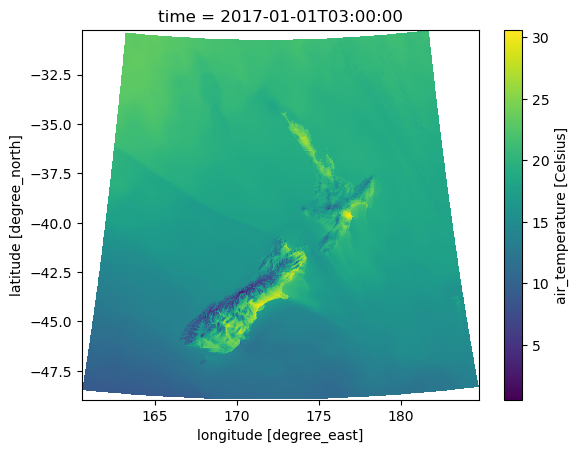

In [9]:
nzra_ds[target_variable].isel(time=0).plot()